**Exponential decay**

Exponential decay of the learning rate is a technique where the learning rate starts at an initial value, \( lr_0 \), and decreases exponentially over time according to the formula:

 *learning rate  = initial learning rate x decay _rate to the power( step / decay_step )*


Here, \( lr_0 \) is the initial learning rate, \( t \) is the current epoch number, and \( s \) is the decay step that determines how quickly the learning rate decreases. For example, if \( lr_0 = 0.01 \) and \( s = 20 \), the learning rate will reduce by a factor of 10 every 20 epochs, going from 0.01 at epoch 0 to 0.001 at epoch 20, and 0.0001 at epoch 40. This approach allows for larger adjustments early in training and finer adjustments later on, aiding in better convergence.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Define the model architecture
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

    for layer in range(100):
        model.add(tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))

    # Add the output layer with 10 neurons and softmax activation
    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    return model

In [12]:
# Load Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

# Split the data into training and validation sets
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

# Normalize the pixel values to the range [0, 1]
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

In [13]:
# Define the optimizer with legacy SGD and learning rate decay
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

# Compute the mean and standard deviation of the training set for normalization
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

# Normalize the datasets using the computed mean and std deviation
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [14]:
# Exponential decay function
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

# Instantiate the decay function with an initial learning rate of 0.01 and decay schedule of 20 epochs
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [15]:
# Set a random seed for reproducibility
tf.random.set_seed(42)

# Build and compile the model
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [16]:
# Number of epochs for training
n_epochs = 10
# Create a learning rate scheduler callback using the exponential decay function
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
# Train the model with the learning rate scheduler callback
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[lr_scheduler])

Epoch 1/10
1719/1719 [==============================] - 44s 20ms/step - loss: 2.2421 - accuracy: 0.1261 - val_loss: 2.3031 - val_accuracy: 0.0994 - lr: 0.0100
Epoch 2/10
1719/1719 [==============================] - 33s 19ms/step - loss: 1.8491 - accuracy: 0.2388 - val_loss: 1.4301 - val_accuracy: 0.3978 - lr: 0.0089
Epoch 3/10
1719/1719 [==============================] - 46s 27ms/step - loss: 1.9456 - accuracy: 0.2234 - val_loss: 1.7817 - val_accuracy: 0.2504 - lr: 0.0079
Epoch 4/10
1719/1719 [==============================] - 33s 19ms/step - loss: 1.4826 - accuracy: 0.3576 - val_loss: 1.3374 - val_accuracy: 0.4420 - lr: 0.0071
Epoch 5/10
1719/1719 [==============================] - 44s 26ms/step - loss: 1.2719 - accuracy: 0.4696 - val_loss: 1.0990 - val_accuracy: 0.5566 - lr: 0.0063
Epoch 6/10
1719/1719 [==============================] - 34s 20ms/step - loss: 1.1707 - accuracy: 0.5150 - val_loss: 0.8692 - val_accuracy: 0.6770 - lr: 0.0056
Epoch 7/10
1719/1719 [========================

313/313 [==============================] - 4s 11ms/step - loss: 0.7871 - accuracy: 0.7053
Test accuracy: 0.7053


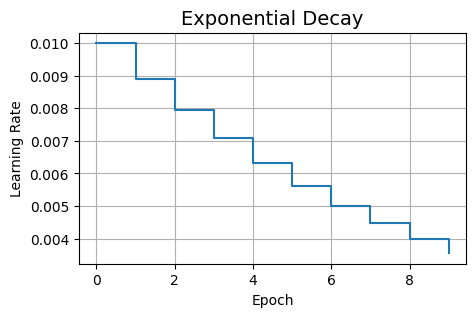

In [17]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Plot the learning rate schedule as a staircase diagram
epochs = np.arange(n_epochs)
learning_rates = [exponential_decay_fn(epoch) for epoch in epochs]

plt.figure(figsize=(5, 3))
plt.step(epochs, learning_rates, where='post')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Exponential Decay', fontsize=14)
plt.grid(True)